# Local Outlier Factor (LOF) 

`LOF(Local Outlier Factor)` 알고리즘은 이웃과 관련하여 주어진 데이터 포인트의 로컬 밀도 편차를 계산하는 비지도 학습 이상 탐지 방법입니다. 

- 각 데이터 포인트의 로컬 밀도를 인접 데이터 포인트와 비교하고 밀도가 낮은 데이터 포인트를 비정상 또는 특이값으로 식별합니다.

다음을 학습 합니다.

- 특이치 검출(novelty detection)과 outlier detection의 차이점  
- 특이치 검출(novelty detection)을 위해 LOF(Local Outlier Factor)를 사용하는 방법
- 비정상(anomaly) 또는 이상치(outlier) 탐지를 위해 LOF(Local Outlier Factor)를 사용하는 방법

In [1]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 불균형 데이터세트 만들기 
- 서로 다른 mechanism 으로 생성된 두가지 data 를 하나로 섞어서 생성

In [15]:
np.random.seed(42)

# inlier data 생성
X_inliers = 0.3* np.random.randn(2000, 2)
print(X_inliers.shape)

# outlier data 생성
X_outliers = np.random.uniform(low=-4, high=0,size=(200 2))

X = np.vstack([X_inliers, X_outliers])
print(X.shape)

n_outliers = len(X_outliers)
# inlier 0, outlier 1 부여
y = np.zeros(len(X), dtype=int)
y[-n_outliers:] = 1

print(y.shape)

print("이상치 비율 = {}".format(len(X_outliers) / len(X)))

(2000, 2)
(2200, 2)
(2200,)
이상치 비율 = 0.09090909090909091


- data 시각화

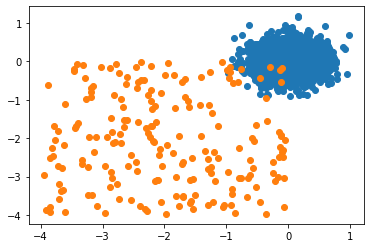

In [22]:
plt.scatter(X_inliers[:, 0], X_inliers[:, 1])
plt.scatter(X_outliers[:, 0], X_outliers[:, 1])

In [23]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('훈련 데이터세트의 레코드 수 : ', X_train.shape[0])
print('테스트 데이터세트의 레코드 수 : ', X_test.shape[0])
print(f"훈련 데이터세트의 minority class 수 : {sorted(Counter(y_train).items())[1][1]}")

훈련 데이터세트의 레코드 수 :  1760
테스트 데이터세트의 레코드 수 :  440
훈련 데이터세트의 minority class 수 : 160


## Outlier/anomaly Detection Vs. Novelty Detection

- LOF(Local Outlier Factor) 알고리즘은 이상치 검출(outlier/anomaly detection) 및 특이치 검출(Novelty Detection)에 모두 사용할 수 있습니다. Outlier / Anomaly Detection 및 Novelty Detection의 차이점은 훈련 데이터 세트에 있습니다.  

    - Outlier/anomaly detection에는 훈련 데이터 세트의 이상치가 포함됩니다. 이 알고리즘은 고밀도 데이터가 있는 영역에 적합하고 outlier 및 anomaly를 무시합니다.

    - Novelty Detection에는 모델을 훈련할 때 normal data point 만 포함됩니다. 그런 다음 모델은 예측을 위해 Outlier/Anomaly가 포함되어 있는 새 데이터 세트를 사용합니다. Novelty Detection의 이상값을 novelty (특이치) 라고도 합니다.

- outlier label 이 있는 데이터 세트가 있는 경우 두가지 모두 사용할 수 있습니다. 그렇지 않으면 정상 데이터만으로 이루어진 훈련 데이터 세트를 얻을 수 없기 때문에 outlier detection 만 사용할 수 있습니다.


- 고려되는 neighbor 수 (파라미터 n_neighbors)는 일반적으로   
    1) 클러스터에 포함해야하는 최소 샘플 수보다 크게 설정되어 다른 샘플이 이 클러스터에 상대적인 로컬 이상치가 될 수 있도록 하고,    
    2) 잠재적 로컬 이상치가 될 수 있는 샘플 수보다 크게 설정됩니다.  
    
    neighbor 를 몇개로 하는지 정해진 것은 없으며 n_neighbors = 20을 사용하면 일반적으로 잘 작동하는 것으로 보입니다.

### Local Outlier Factor (LOF) 를 사용한 특이치 검출 (Novelty Detection)

- Novelty Detection을 사용하려면 LOF 의 novelty 파라미터를 True로 설정해야 합니다. 
```
LocalOutlierFactor(n_neighbors=20, novelty=True)
```
- normal data로만 구성된 train set으로 모델을 fitting 하고 outlier를 포함하는 test dataset을 predict 합니다.

In [27]:
# 훈련 데이터 세트에 normal 데이터만 유지
X_train_normal = X_train[np.where(y_train == 0)]

# novelty detection을 위한 LOF(Local Outlier factor) fitting -> normal data 만으로 fit
lof_novelty = LocalOutlierFactor(n_neighbors=20, novelty=True).fit(X_train_normal)

# test dataset 에서 novelty 예측
prediction_novelty = lof_novelty.predict(X_test)

# Change the anomalies' values to make it consistent with the true values
prediction_novelty = [1 if i==-1 else 0 for i in prediction_novelty]

# Check the model performance
print(classification_report(y_test, prediction_novelty))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.87      0.97      0.92        40

    accuracy                           0.98       440
   macro avg       0.93      0.98      0.95       440
weighted avg       0.99      0.98      0.98       440



### LOF(Local Outlier Factor)를 사용한 이상치 감지 (outlier detection) 
- 위와 동일한 데이터 세트에서 outlier detection을 훈련하고 예측하기 위한 LOF(Local Outlier Factor).   
- normal 과 outlier 가 섞여 있는 dataset 으로 fitting 해야 합니다.
- Outlier Detection algorithm을 활성화하려면 novelty=`False`로 설정해야 합니다. 
```
LocalOutlierFactor(n_neighbors=5, novelty=False)  
```
- X_test 로 측정한 모델간 비교를 위해 X_test

In [28]:
# The local outlier factor (LOF) model for outlier detection
lof_outlier = LocalOutlierFactor(n_neighbors=20, novelty=False)

# Predict novelties - normal 과 outlier 가 섞인 data 로 fit
prediction_outlier = lof_outlier.fit_predict(X_test)

# Change the anomalies' values to make it consistent with the true values
prediction_outlier = [1 if i==-1 else 0 for i in prediction_outlier]
# Check the model performance
print(classification_report(y_test, prediction_outlier))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       400
           1       0.50      0.33      0.39        40

    accuracy                           0.91       440
   macro avg       0.72      0.65      0.67       440
weighted avg       0.90      0.91      0.90       440



- 시각화를 통한 특이치 검축 / 이상치 검출 결과 비교

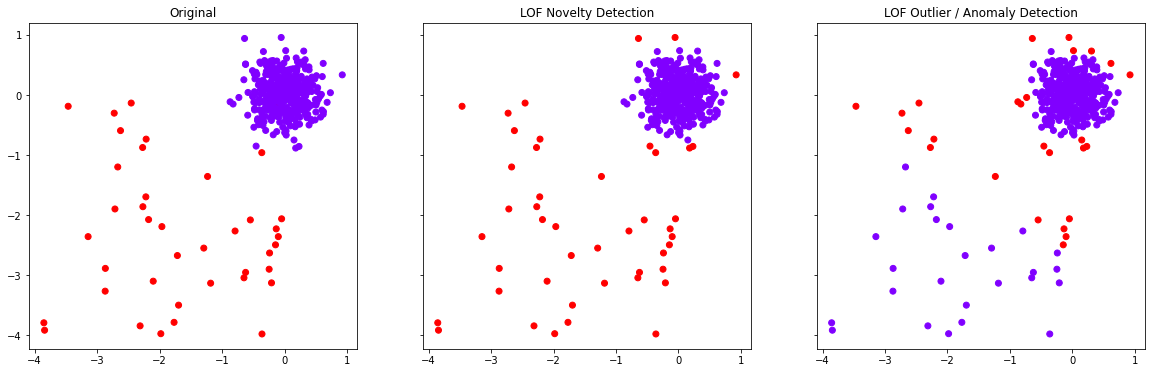

In [29]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = y_test
df_test['prediction_novelty'] = prediction_novelty
df_test['prediction_outlier'] = prediction_outlier

# Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)=plt.subplots(1,3, sharey=True, figsize=(20,6))
# original data (정상 + 이상치)
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')

# Local Outlier Factor (LOF) Novelty Detection
ax1.set_title('LOF Novelty Detection')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['prediction_novelty'], cmap='rainbow')

# Local Outlier Factor (LOF) Outlier / Anomaly Detection
ax2.set_title('LOF Outlier / Anomaly Detection')
ax2.scatter(df_test['feature1'], df_test['feature2'], c=df_test['prediction_outlier'], cmap='rainbow')
plt.show()